In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dtnnlib as dtnn

In [3]:
from sklearn.datasets import make_classification, make_blobs

In [4]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [5]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## Viz Residual

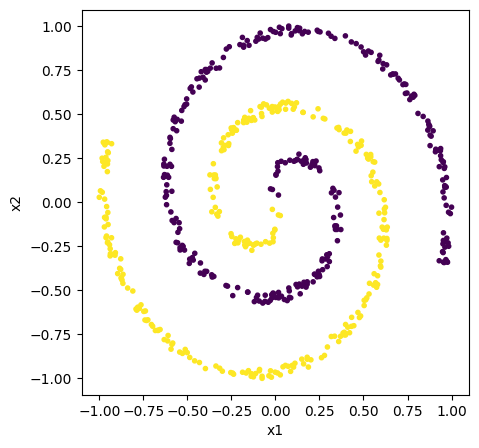

In [6]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [7]:
xx, yy = xx.to(device), yy.to(device)

In [8]:
class SoftmaxTemp(nn.Module):
    def __init__(self, temp=3.0):
        super().__init__()
        self.temp = temp
        
    def forward(self, x):
        return torch.softmax(x*self.temp, dim=-1)

#### Directional Similarity Based On Gradient Magnitude

In [9]:
def directional_similarity_mag(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
#     print(point.shape)
#     print(direction.shape)
#     print(other_points.shape)
    
#     C = torch.Tensor([[0]]).to(point.device)
    C = torch.norm(direction, p=2, dim=-1, keepdim=True)
#     print(C.shape)
    C = C.unsqueeze(1)
    
    ### direction towards +ve x-axis
#     direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized
    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=2, dim=-1, keepdim=True)
#     print(vecs.shape, vecs_mag.shape, C.shape)
    vecs_dirn = vecs/(vecs_mag+1e-11+C) ## 1e-B for stability
    
#     print(vecs_dirn.shape, direction.unsqueeze(2).shape)
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
#     print(yout.shape, vecs_mag.shape)
    yout = yout/(vecs_mag+1e-11+C) ## gives inportance to similarity
    return yout.squeeze(-1)

In [10]:
def directional_similarity_mag_euclidian(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    LP = 2
    vecs = other_points.unsqueeze(0)-(point+direction).unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=LP, dim=-1, keepdim=True)
#     return 1-vecs_mag.squeeze(-1)
    return 1*torch.norm(direction, dim=-1, keepdim=True)-vecs_mag.squeeze(-1)

In [11]:
def directional_similarity_mag_maximum(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    ## Since the maxima is at 1/2th the distance - direction is doubled to manage
    direction = direction*2
    
#     C = torch.Tensor([[0]]).to(point.device)
    C = torch.norm(direction, p=2, dim=-1, keepdim=True)
    C = C.unsqueeze(1)
    
    
    vecs = other_points.unsqueeze(0) - (point+direction).unsqueeze(1)
    vecs_mag_from_target = torch.norm(vecs, p=2, dim=-1, keepdim=True)
    
    vecs2 = other_points.unsqueeze(0) - (point).unsqueeze(1)
    vecs_mag = torch.norm(vecs2, p=2, dim=-1, keepdim=True)
    vecs_angle_from_source = vecs2/(vecs_mag+1e-11) ## 1e-B for stability
    
    vecs_mag_from_target = torch.maximum(vecs_mag, vecs_mag_from_target)
    
#     vecs_angle_from_source = torch.acos(vecs_angle_from_source)
    
    ### direction towards +ve x-axis
    direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized

#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_angle_from_source, direction.unsqueeze(2))## gives importance to direction
    yout = yout/(vecs_mag_from_target+1e-11) ## gives inportance to similarity
#     yout = yout*(vecs_mag_from_target) ## gives inportance to similarity
    yout = yout*C

    return yout.squeeze(-1)

In [12]:
point = torch.Tensor([[-0.5, 1]])
direction = torch.Tensor([[0.5, 0.5]])*0.1

In [13]:
num_points = 100

C = 1.3
## get dif in point and dirn
px, py = (point+direction*0.5)[0].tolist()
mag = (direction**2).sum().sqrt()

left = px-mag*C
right = px+mag*C
top = py-mag*C
bottom = py+mag*C


X1 = np.linspace(left, right, num_points)
X2 = np.linspace(top, bottom, num_points)
X1, X2 = np.meshgrid(X1, X2)
XX_grid = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)])

In [14]:
sim = directional_similarity_mag_maximum(point, direction, XX_grid)
print(sim.max())

tensor(1.4122)


In [15]:
## reduce output variance
sim = (sim.abs() ** (1/10)) *sim.sign()

tensor([[7.0155e-05, 7.0095e-05]])


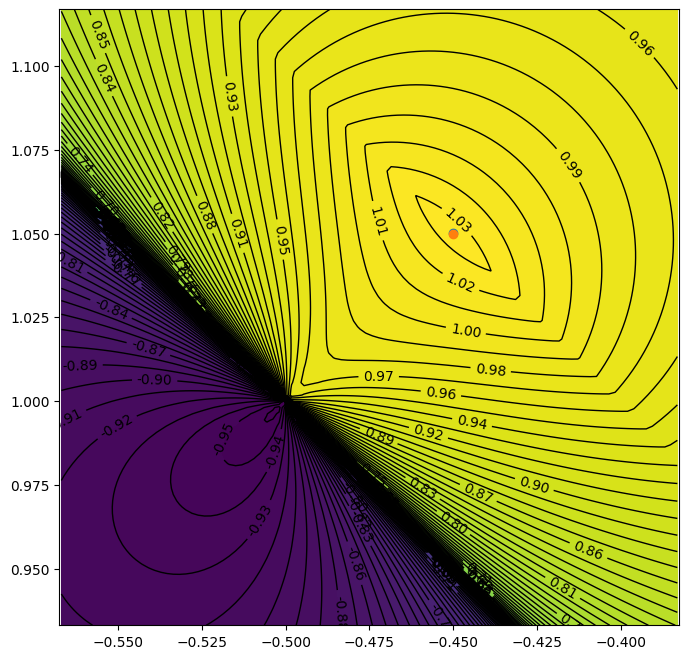

In [16]:
%matplotlib inline
LVLs=200
# LVLs = np.linspace(sim.min(), sim.max(), 20)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs)
cs = plt.contour(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

xx_max = XX_grid[sim.argmax()]
plt.scatter(*xx_max)
plt.scatter(*(point+direction).t())
plt.axis('equal')
print(xx_max-direction-point) ## should give zero for valid maximum


## With Residual Framework

In [89]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h, scale=10):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.BatchNorm1d(h),
#             nn.LayerNorm(h, elementwise_affine=False),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=scale, shift_init=0.0), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = dtnn.DistanceTransform(2, 2, bias=True)
        
    def forward(self, x):
#         return torch.sigmoid(self.clf(x + self.net(x)))
        return self.clf(x + self.net(x))

In [81]:
yy = yy.reshape(-1)

In [82]:
net = ResidualMLP(10, scale=10.0).to(device)

lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# criterion = nn.BCELoss()
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
LR = 0.01
min_sim = 0.00 #-500## 0.0

In [83]:
net.net[0].centers.shape, net.net[-1].weight.shape

(torch.Size([10, 2]), torch.Size([2, 10]))

In [84]:
# torch.norm(net.net[-1].weight.data, dim=1, keepdim=True)

In [85]:
net

ResidualMLP(
  (net): Sequential(
    (0): DistanceTransform()
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): ScaleShift()
      (1): Softmax(dim=-1)
    )
    (3): OneActiv()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
  (clf): DistanceTransform()
)

Epoch: 99, Acc:0.62, Loss:0.6080917119979858
Epoch: 199, Acc:0.65, Loss:0.7078233361244202
Epoch: 299, Acc:0.60, Loss:0.7509246468544006
Epoch: 399, Acc:0.50, Loss:0.7063541412353516
Epoch: 499, Acc:0.50, Loss:0.6931620836257935
Epoch: 599, Acc:0.50, Loss:0.6931472420692444
Epoch: 699, Acc:0.50, Loss:0.6931471228599548
Epoch: 799, Acc:0.49, Loss:0.6931473016738892
Epoch: 899, Acc:0.51, Loss:0.6931473016738892
Epoch: 999, Acc:0.50, Loss:0.6931473016738892


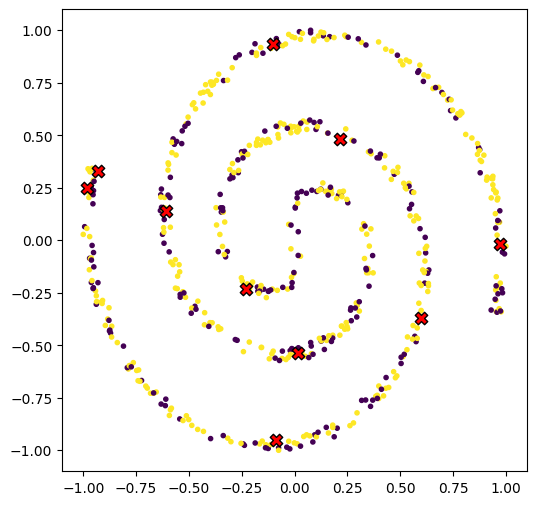

Epoch: 1099, Acc:0.52, Loss:0.6931473016738892
Epoch: 1199, Acc:0.49, Loss:0.6931473016738892
Epoch: 1299, Acc:0.48, Loss:0.6931473016738892
Epoch: 1399, Acc:0.51, Loss:0.6931473016738892
Epoch: 1499, Acc:0.46, Loss:0.6931473016738892
Epoch: 1599, Acc:0.50, Loss:0.6931473016738892
Epoch: 1699, Acc:0.50, Loss:0.6931473016738892
Epoch: 1799, Acc:0.53, Loss:0.6931473016738892
Epoch: 1899, Acc:0.51, Loss:0.6931473016738892
Epoch: 1999, Acc:0.47, Loss:0.6931473016738892


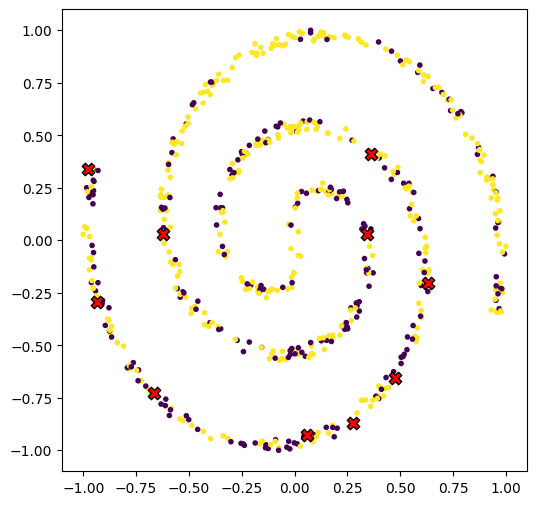

Epoch: 2099, Acc:0.47, Loss:0.6931473016738892
Epoch: 2199, Acc:0.52, Loss:0.6931473016738892
Epoch: 2299, Acc:0.50, Loss:0.6931473016738892
Epoch: 2399, Acc:0.49, Loss:0.6931473016738892
Epoch: 2499, Acc:0.47, Loss:0.6931473016738892
Epoch: 2599, Acc:0.51, Loss:0.6931473016738892
Epoch: 2699, Acc:0.50, Loss:0.6931473016738892
Epoch: 2799, Acc:0.51, Loss:0.6931473016738892
Epoch: 2899, Acc:0.50, Loss:0.6931473016738892
Epoch: 2999, Acc:0.49, Loss:0.6931473016738892


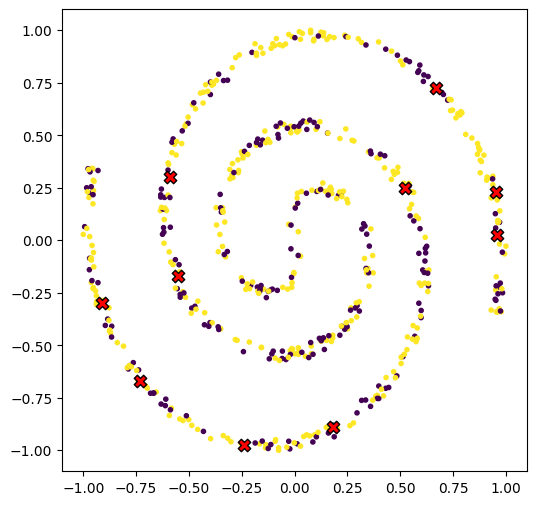

Epoch: 3099, Acc:0.51, Loss:0.6931473016738892
Epoch: 3199, Acc:0.49, Loss:0.6931473016738892
Epoch: 3299, Acc:0.51, Loss:0.6931473016738892
Epoch: 3399, Acc:0.52, Loss:0.6931473016738892
Epoch: 3499, Acc:0.49, Loss:0.6931473016738892
Epoch: 3599, Acc:0.50, Loss:0.6931473016738892
Epoch: 3699, Acc:0.47, Loss:0.6931473016738892
Epoch: 3799, Acc:0.49, Loss:0.6931473016738892
Epoch: 3899, Acc:0.47, Loss:0.6931473016738892
Epoch: 3999, Acc:0.48, Loss:0.6931473016738892


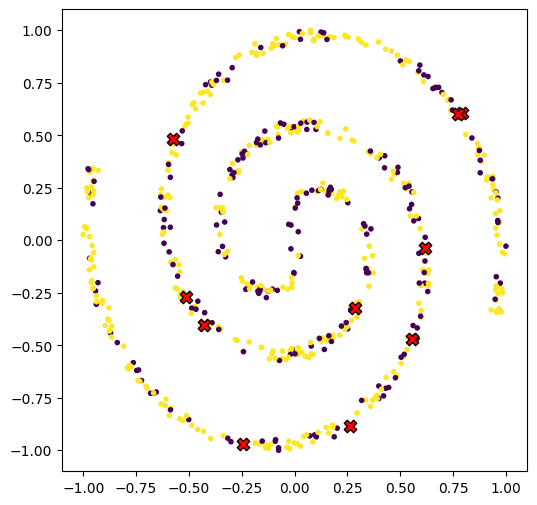

Epoch: 4099, Acc:0.51, Loss:0.6931473016738892
Epoch: 4199, Acc:0.49, Loss:0.6931473016738892
Epoch: 4299, Acc:0.44, Loss:0.6931473016738892
Epoch: 4399, Acc:0.49, Loss:0.6931473016738892
Epoch: 4499, Acc:0.47, Loss:0.6931473016738892
Epoch: 4599, Acc:0.50, Loss:0.6931473016738892
Epoch: 4699, Acc:0.49, Loss:0.6931473016738892
Epoch: 4799, Acc:0.52, Loss:0.6931473016738892
Epoch: 4899, Acc:0.51, Loss:0.6931473016738892
Epoch: 4999, Acc:0.48, Loss:0.6931473016738892


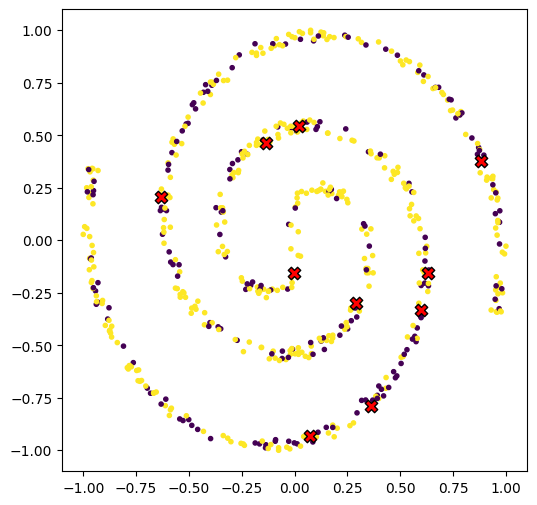

Epoch: 5099, Acc:0.51, Loss:0.6931473016738892
Epoch: 5199, Acc:0.47, Loss:0.6931473016738892
Epoch: 5299, Acc:0.48, Loss:0.6931473016738892
Epoch: 5399, Acc:0.49, Loss:0.6931473016738892
Epoch: 5499, Acc:0.45, Loss:0.6931473016738892
Epoch: 5599, Acc:0.50, Loss:0.6931473016738892
Epoch: 5699, Acc:0.49, Loss:0.6931473016738892
Epoch: 5799, Acc:0.50, Loss:0.6931473016738892
Epoch: 5899, Acc:0.50, Loss:0.6931471824645996
Epoch: 5999, Acc:0.50, Loss:0.6931471228599548


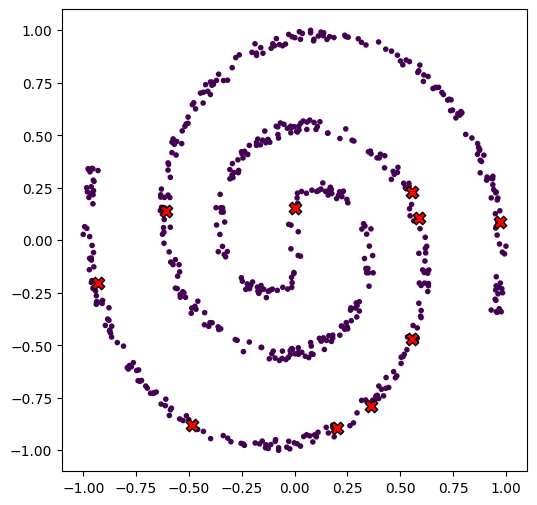

Epoch: 6099, Acc:0.50, Loss:0.6931471228599548
Epoch: 6199, Acc:0.51, Loss:0.6931471824645996
Epoch: 6299, Acc:0.50, Loss:0.6931471228599548
Epoch: 6399, Acc:0.52, Loss:0.6931471824645996
Epoch: 6499, Acc:0.50, Loss:0.6931471824645996
Epoch: 6599, Acc:0.52, Loss:0.6931473016738892
Epoch: 6699, Acc:0.51, Loss:0.6931472420692444
Epoch: 6799, Acc:0.54, Loss:0.6931471824645996
Epoch: 6899, Acc:0.50, Loss:0.6931471228599548
Epoch: 6999, Acc:0.50, Loss:0.6931471228599548


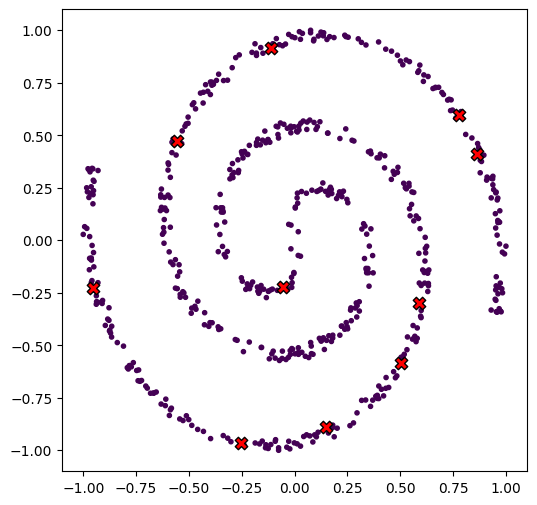

Epoch: 7099, Acc:0.50, Loss:0.6931471228599548
Epoch: 7199, Acc:0.51, Loss:0.6931471824645996
Epoch: 7299, Acc:0.50, Loss:0.6931471824645996
Epoch: 7399, Acc:0.51, Loss:0.6931471824645996
Epoch: 7499, Acc:0.53, Loss:0.6931471824645996
Epoch: 7599, Acc:0.50, Loss:0.6931471228599548
Epoch: 7699, Acc:0.50, Loss:0.6931471228599548
Epoch: 7799, Acc:0.50, Loss:0.6931471228599548
Epoch: 7899, Acc:0.52, Loss:0.6931471824645996
Epoch: 7999, Acc:0.51, Loss:0.6931473016738892


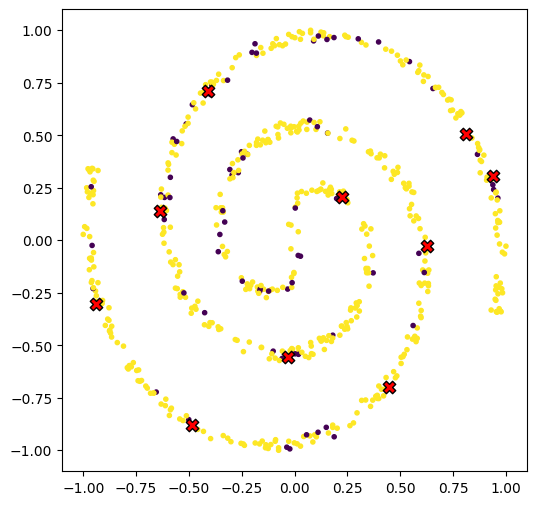

Epoch: 8099, Acc:0.51, Loss:0.6931472420692444
Epoch: 8199, Acc:0.50, Loss:0.6931471228599548
Epoch: 8299, Acc:0.50, Loss:0.6931471228599548
Epoch: 8399, Acc:0.50, Loss:0.6931471824645996
Epoch: 8499, Acc:0.55, Loss:0.6931473016738892
Epoch: 8599, Acc:0.50, Loss:0.6931471824645996
Epoch: 8699, Acc:0.50, Loss:0.6931471228599548
Epoch: 8799, Acc:0.53, Loss:0.6931473016738892
Epoch: 8899, Acc:0.52, Loss:0.6931473016738892
Epoch: 8999, Acc:0.50, Loss:0.6931471228599548


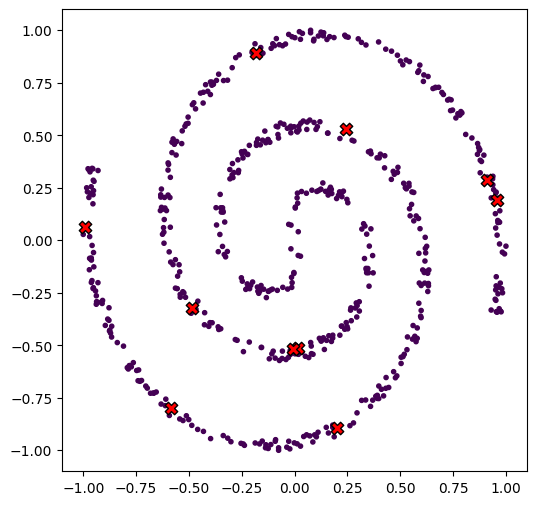

Epoch: 9099, Acc:0.50, Loss:0.6931471228599548
Epoch: 9199, Acc:0.52, Loss:0.6931471824645996
Epoch: 9299, Acc:0.50, Loss:0.6931471228599548
Epoch: 9399, Acc:0.50, Loss:0.6931471228599548
Epoch: 9499, Acc:0.50, Loss:0.6931471228599548
Epoch: 9599, Acc:0.50, Loss:0.6931472420692444
Epoch: 9699, Acc:0.60, Loss:0.6228691935539246
Epoch: 9799, Acc:0.50, Loss:0.6931669116020203
Epoch: 9899, Acc:0.50, Loss:0.6931471824645996
Epoch: 9999, Acc:0.50, Loss:0.6931472420692444


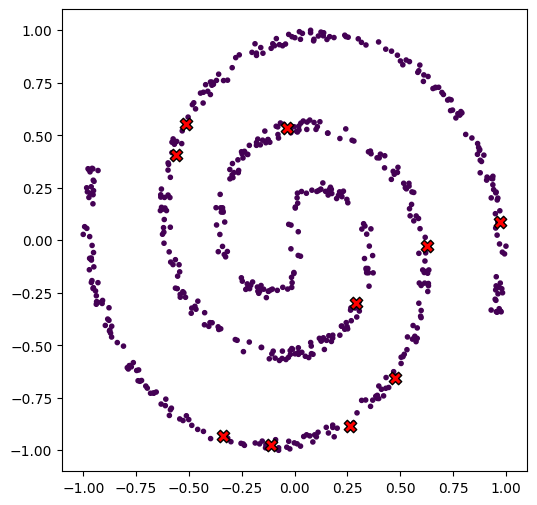

In [86]:
for epoch in range(10000):
#     wnorm = torch.norm(net.net[-1].weight.data, dim=0, keepdim=True)
#     net.net[-1].weight.data *= wnorm.clamp(0.01, 2.0)/wnorm
    
    yout = net(xx)
    loss = criterion(yout, yy.reshape(-1).type(torch.long))

    optimizer.zero_grad()
    loss.backward()
    ########################################################
    ### Do discrete optimization here
    if (epoch+0)%5 <= 0:
        sim = directional_similarity_(
                    net.net[0].centers, 
                    -net.net[0].centers.grad * LR, 
                    xx)
        
        ## Method 1 (no filtering)
        if epoch == 0:
            sim_x = sim.argmax(dim=-1)
            net.net[0].centers.data = xx[sim_x]
            
        else:
        ## Method 2 (filtering)
            maxval, maxidx = sim.max(dim=-1)
            valid_mask = maxval > min_sim
            net.net[0].centers.data[valid_mask] = xx[maxidx][valid_mask]
    
    ########################################################
#         optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    else:
        net.net[0].centers.grad = None
        optimizer.step()

    if (epoch+1)%100 == 0:
#         accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()    
        accuracy = (torch.argmax(yout, dim=1).type(torch.float32) == yy).type(torch.float).mean()           
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
#         out = (yout.data.cpu().numpy()>0.5).astype(int)
        out = torch.argmax(yout, dim=1).data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], facecolor='red', marker= 'X', edgecolor='k', s=80)
        plt.show()

In [87]:
sim.max(), sim.min()

(tensor(1.6197e-10, grad_fn=<MaxBackward1>),
 tensor(-2.7206e-10, grad_fn=<MinBackward1>))

## With MLP framework 2 layer optimization discrete only

In [ ]:
class DiscreteMLP(nn.Module):
    
    def __init__(self, h, scale=10):
        super().__init__()
        self.net = nn.Sequential(
            dtnn.DistanceTransform(2, h),
            nn.BatchNorm1d(h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=scale, shift_init=0.0), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 1, bias=False),
            )
        
    def forward(self, x):
        self.net[1].weight.data.abs_()
        return torch.sigmoid(self.net(x))

In [ ]:
yy = yy.reshape(-1, 1)

In [ ]:
net = DiscreteMLP(10, scale=1.0).to(device)

criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()
LR = 0.01
min_sim = 0.00 #-500## 0.0

In [ ]:
net.net[0].centers.shape, net.net[-1].weight.shape

In [ ]:
net

In [ ]:
net(xx).shape

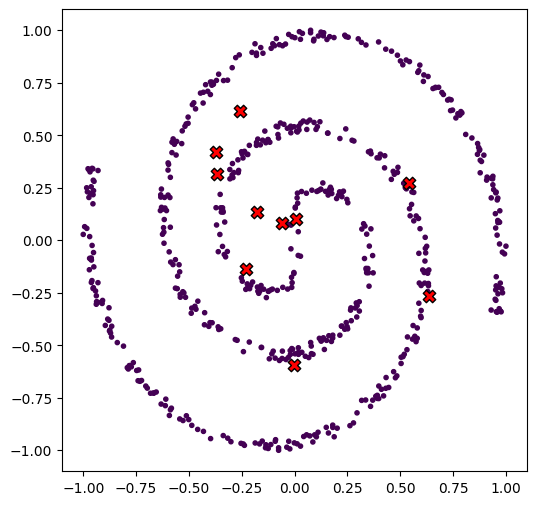

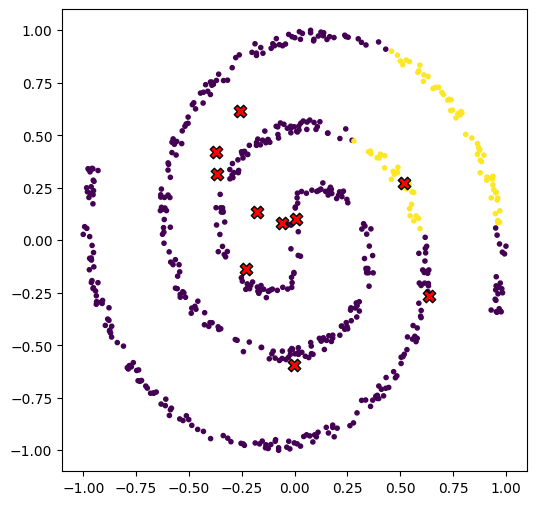

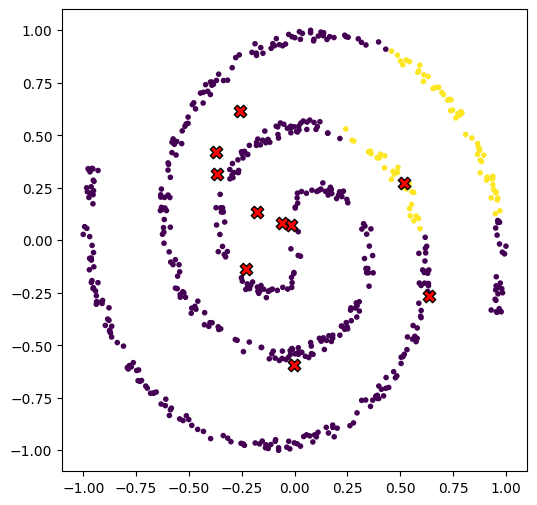

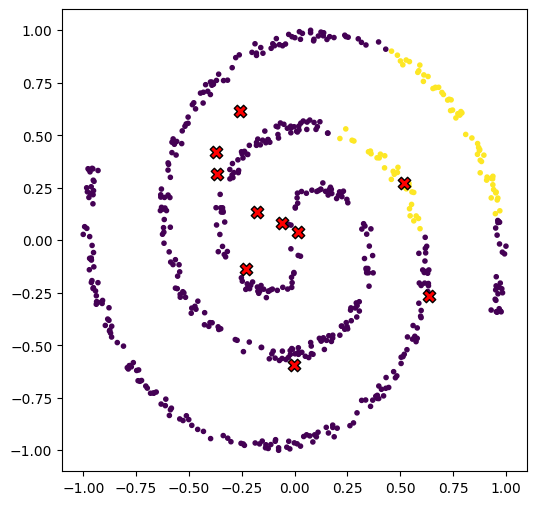

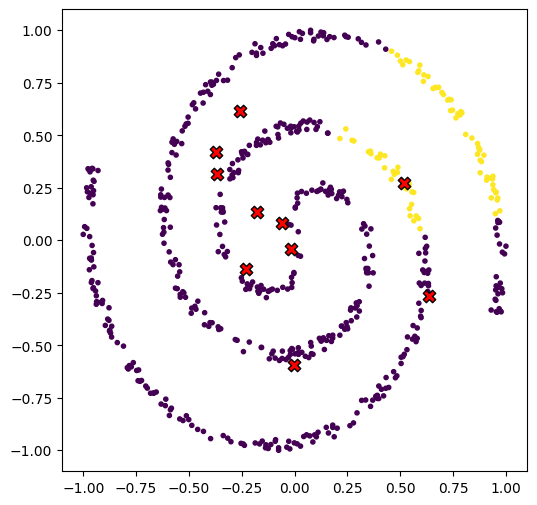

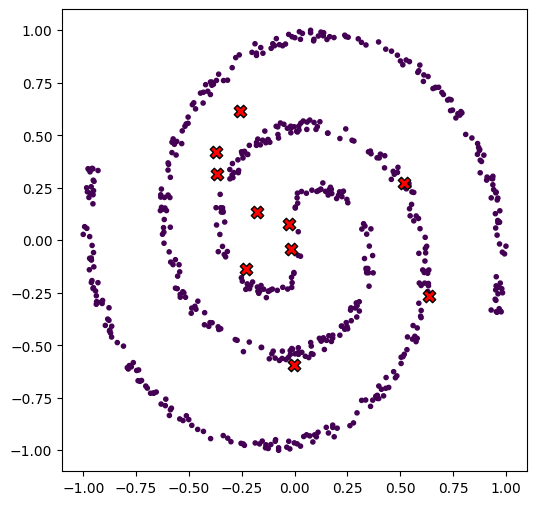

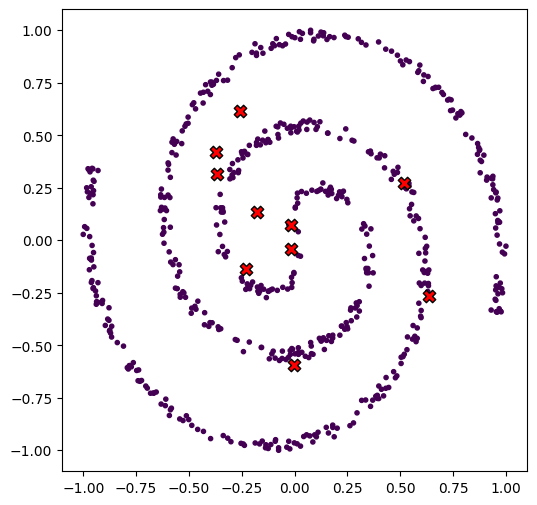

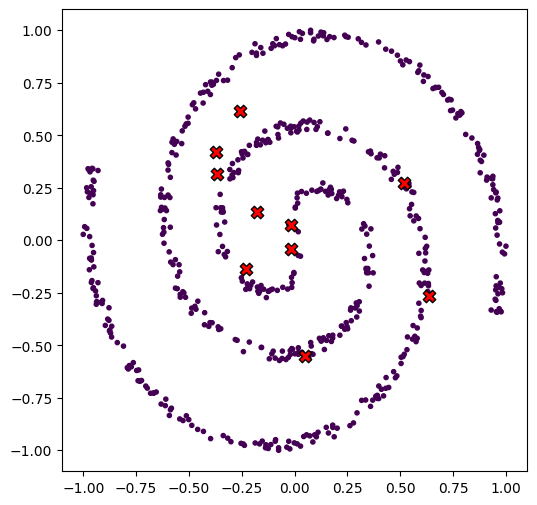

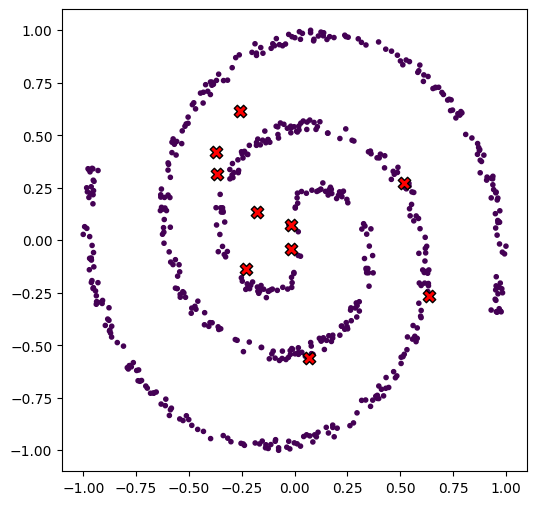

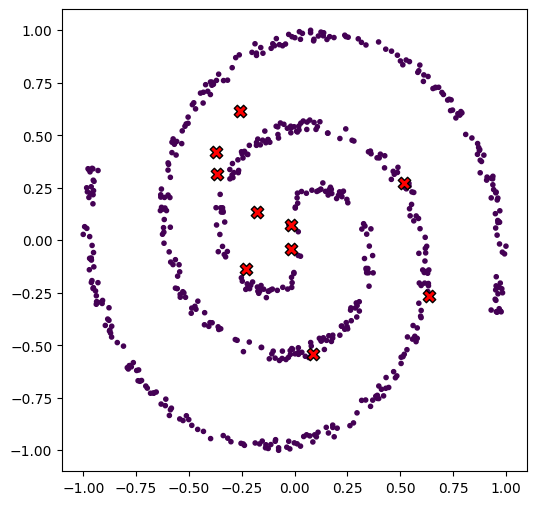

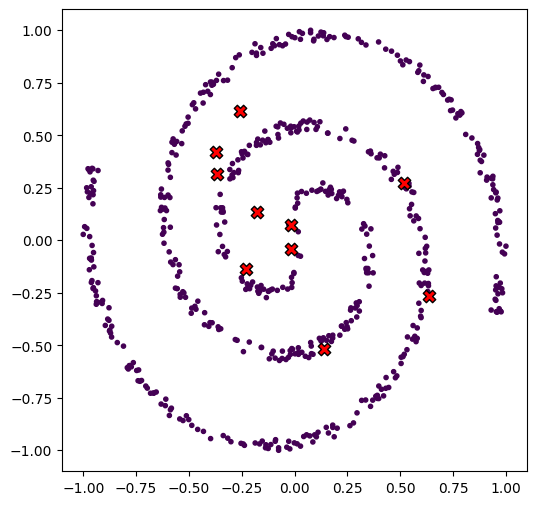

In [ ]:
for epoch in range(10000):
#     wnorm = torch.norm(net.net[-1].weight.data, dim=0, keepdim=True)
#     net.net[-1].weight.data *= wnorm.clamp(0.01, 2.0)/wnorm
    
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    ########################################################
    ### Do discrete optimization here
    sim = directional_similarity_mag(
                net.net[0].centers, 
                -net.net[0].centers.grad * LR, 
                xx)

#     ## Method 1 (no filtering)
#     if epoch == -1:
#         sim_x = sim.argmax(dim=-1)
#         net.net[0].centers.data = xx[sim_x]
#         net.net[-1].weight.data = yy[sim_x].t()

#     else:
#     ## Method 2 (filtering)
#         maxval, maxidx = sim.max(dim=-1)
#         valid_mask = maxval > min_sim
#         net.net[0].centers.data[valid_mask] = xx[maxidx][valid_mask]
#         net.net[-1].weight.data[:, valid_mask] = yy[maxidx][valid_mask].t()

    ### update only one of the neuron at a time
    maxval, maxidx = sim.max(dim=-1)
    neuron_idx = maxval.argmax()
    sim_x = maxidx[neuron_idx]
    net.net[0].centers.data[neuron_idx] = xx[sim_x]
    net.net[-1].weight.data[:, neuron_idx] = yy[sim_x].t()
    
    ########################################################
    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()    
#         accuracy = (torch.argmax(yout, dim=1).type(torch.float32) == yy).type(torch.float).mean()           
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
#         out = torch.argmax(yout, dim=1).data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], facecolor='red', marker= 'X', edgecolor='k', s=80)
        plt.show()

In [ ]:
net.net[-1].weight

In [149]:
net.net[-1].weight.shape

torch.Size([1, 10])

In [181]:
net.net[0].centers

Parameter containing:
tensor([[-0.3974, -0.9444],
        [-0.3974, -0.9444],
        [-0.3974, -0.9444],
        [-0.3974, -0.9444],
        [-0.3974, -0.9444],
        [-0.3974, -0.9444],
        [-0.3974, -0.9444],
        [-0.3974, -0.9444],
        [-0.3974, -0.9444],
        [-0.3974, -0.9444]], requires_grad=True)

In [161]:
sim.shape

torch.Size([10, 600])

In [164]:
v, i = sim.max(dim=1)

In [167]:
v.argmax()

tensor(0)

In [168]:
i[v.argmax()]

tensor(512)

In [188]:
yy

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      